#Paquetes necesarios

In [174]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

TAREA: Captura una o varias imágenes con monedas no solapadas y algún objeto que no lo sea. Filtra los contornos que no se correpondan con monedas, y muestra el número total de monedas presentes en la imagen.

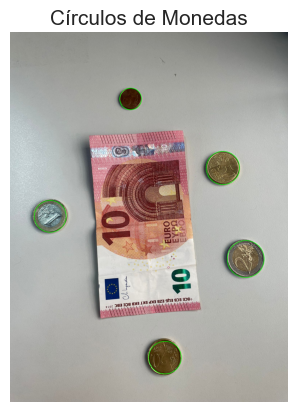

Número total de monedas en la imagen: 5


In [179]:
#Cargamos las imagenes
dinero = cv2.imread('dinero.jpg') 

#Recordando que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr RGB
dinero_rgb = cv2.cvtColor(dinero, cv2.COLOR_BGR2RGB)

#Conversión a gris
gris = cv2.cvtColor(dinero, cv2.COLOR_BGR2GRAY)
#Suaviza altas frecuencias
pimg = cv2.medianBlur(gris, 7)
#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        dp=1,
        minDist=100,  # distancia mínima entre círculos
        param1=190, # Valor del gradiente
        param2=50, #Umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

if circ is not None:

    circulos = np.uint16(np.around(circ))

    # Inicializamos un contador de monedas
    contador_monedas = 0

    for circulo in circulos[0, :]:
        x, y, radio = circulo

        # Define un ROI (Región de interés) alrededor del círculo
        roi = dinero[y - radio:y + radio, x - radio:x + radio]

        # Calcula la relación de aspecto del ROI
        altura, ancho, _ = roi.shape
        relacion_aspecto = ancho / altura

        # Si la relación de aspecto está cerca de 1 (cercano a un círculo), consideramos que es una moneda
        if 0.9 < relacion_aspecto < 1.1:
            contador_monedas += 1
            cv2.circle(dinero, (x, y), radio, (0, 255, 0), 2)
            
    # Muestra el resultado con los círculos de las monedas
    plt.axis("off")
    plt.imshow(cv2.cvtColor(dinero, cv2.COLOR_BGR2RGB))
    plt.title('Círculos de Monedas')
    plt.show()

    print(f'Número total de monedas en la imagen: {contador_monedas}')
else:
    print('No se encontraron círculos en la imagen.')


TAREA: Captura una o varias imágenes con monedas no solapadas, y otras con monedas solapadas. Identificada una moneda de un euro en la imagen, por ejemplo con un clic de ratón, calcular la cantidad de dinero presente en la imagen. ¿Qué problemas han observado?




In [357]:
dinero = cv2.imread('dinero.jpg')
#dinero = cv2.imread('solapadas.jpg')

dinero_rgb = cv2.cvtColor(dinero, cv2.COLOR_BGR2RGB)

# Conversión a gris y suavizado de altas frecuencias
gris = cv2.cvtColor(dinero, cv2.COLOR_BGR2GRAY)
pimg = cv2.medianBlur(gris, 7)

# Localizar círculos
circ = cv2.HoughCircles(
        pimg,  
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=100,  
        param1=190, 
        param2=50, 
        minRadius=50,  
        maxRadius=150,  
    )

# Contador de valor de las monedas
total = 0 

# Comprobamos si existen círculos en la imagen
if circ is not None:
    circulos = np.uint16(np.around(circ))

    for circulo in circulos[0, :]:
        x, y, radio = circulo

        # Define un ROI (Región de interés) alrededor del círculo
        roi = dinero[y - radio:y + radio, x - radio:x + radio]

        # Calcula la relación de aspecto del ROI
        altura, ancho, _ = roi.shape
        relacion_aspecto = ancho / altura

        # Consideración de monedas
        if 0.9 < relacion_aspecto < 1.1:
            if 80 < radio < 90:  # Diametro de la moneda de 1e.
                total += 1
                cv2.circle(dinero, (x, y), radio, (0, 255, 0), 2)   #Marcamos la moneda de 1e
            elif 90 < radio < 100:
                total += 0.5
            elif 50 < radio < 70:
                total += 0.01
            elif 100 < radio < 110:
                total += 2
            elif radio == 90:
                total += 0.2
            
dinero_redimensionado = cv2.resize(dinero, (600, 700)) # (dinero, (ancho x alto))

# Muestra el resultado marcando la/las monedas de 1e
cv2.imshow('Calculo de monedas', dinero_redimensionado)

# Función para manejar clics en la imagen resultante
def detectar_clic(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print("La cantidad total de las monedas de la imagen:", total)

# Asigna la función de manejo de clics a la ventana
cv2.setMouseCallback('Calculo de monedas', detectar_clic)

cv2.waitKey(0)
cv2.destroyAllWindows()

La cantidad total de las monedas de la imagen: 3.71


TAREA: Estas tres imágenes han sido extraidas de las imágenes de mayor tamaño contenidas en la carpeta. Determina patrones geométricos para cada una de las tres clases y evalúa los aciertos y fallos con las imágenes completas la matriz de confusión. Para cada clase, determina el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifica incorrectamente por cada una de las otras dos clases.

El el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas en dicho trabajo fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación del cuadrado del perímetro con el área)
- Relación del área con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Las métricas se utilizan para mostrar la bondad de un clasificador, la siguiente celda obtiene varias para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador par alas distintas clases consideradas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente

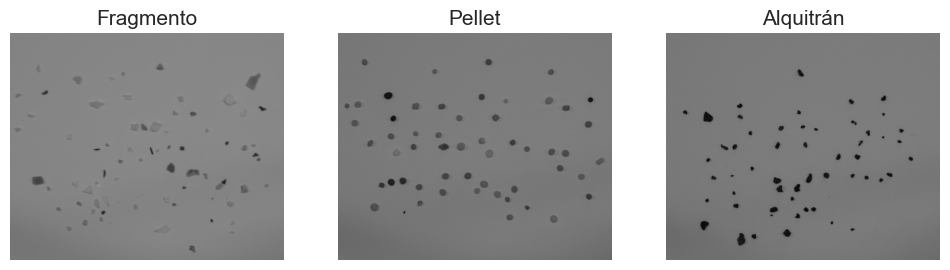

In [346]:
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Se cargan las tres imágenes: fragmentos, pellets y alquitrán
frag = cv2.imread('fragment-03-olympus-10-01-2020.JPG')
pellet = cv2.imread('pellet-03-olympus-10-01-2020.JPG')
alqui = cv2.imread('tar-03-olympus-10-01-2020.JPG')

# Recortar las imágenes para evitar las sombras que aparecen
inicio_columna = 750
fin_columna = 4000
inicio_fila = 0
fin_fila = 2700

# Recortar las imágenes para evitar problemas con las sombras de las imágenes
frag_gris = frag[inicio_fila:fin_fila, inicio_columna:fin_columna]
pellet_gris = pellet[inicio_fila:fin_fila, inicio_columna:fin_columna]
alqui_gris = alqui[inicio_fila:fin_fila, inicio_columna:fin_columna]

# Convertir las imágenes recortadas a escala de grises
frag_gris = cv2.cvtColor(frag_gris, cv2.COLOR_BGR2GRAY)
pellet_gris = cv2.cvtColor(pellet_gris, cv2.COLOR_BGR2GRAY)
alqui_gris = cv2.cvtColor(alqui_gris, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro de suavizado a la imagen de fragmentos
frag_gris = cv2.GaussianBlur(frag_gris, (25, 25), 0)

# Mostrar las imágenes recortadas
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.title('Fragmento')
plt.axis("off")
plt.imshow(cv2.cvtColor(frag_gris, cv2.COLOR_BGR2RGB))

plt.subplot(132)
plt.title('Pellet')
plt.axis("off")
plt.imshow(cv2.cvtColor(pellet_gris, cv2.COLOR_BGR2RGB))

plt.subplot(133)
plt.title('Alquitrán')
plt.axis("off")
plt.imshow(cv2.cvtColor(alqui_gris, cv2.COLOR_BGR2RGB))

plt.show()

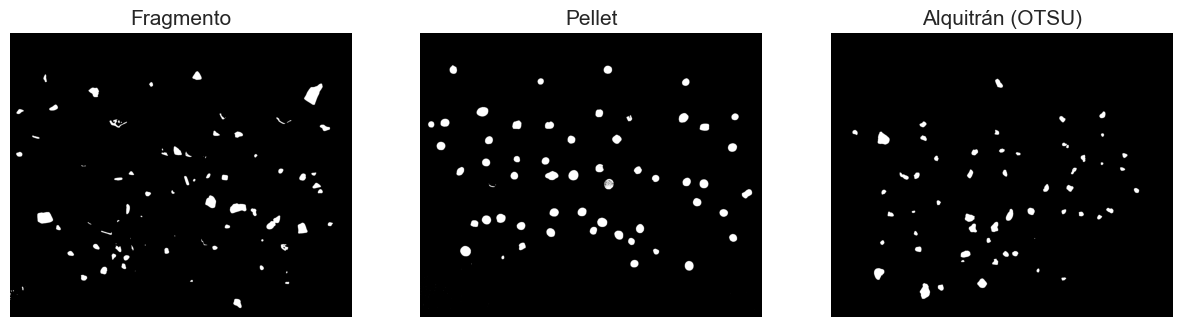

In [347]:
# Umbralizado 'fragmentos' y 'pellet' 
# Se ha tenido que jugar con los valores de umbralizado ya que detectba las sombras del folio sobre el que están los fragmentos
_,frag_umbral = cv2.threshold(frag_gris,115,255,cv2.THRESH_BINARY_INV)
_,pel_umbral = cv2.threshold(pellet_gris,100,255,cv2.THRESH_BINARY_INV)

# Umbralizado con método de Otsu
_,tar_umbral = cv2.threshold(alqui_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Mostrar las imágenes umbralizadas
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.title('Fragmento')
plt.axis("off")
plt.imshow(frag_umbral,cmap='gray') 

plt.subplot(132)
plt.title('Pellet')
plt.axis("off")
plt.imshow(pel_umbral,cmap='gray') 

plt.subplot(133)
plt.title('Alquitrán (OTSU)')
plt.axis("off")
plt.imshow(tar_umbral,cmap='gray') 

plt.show()

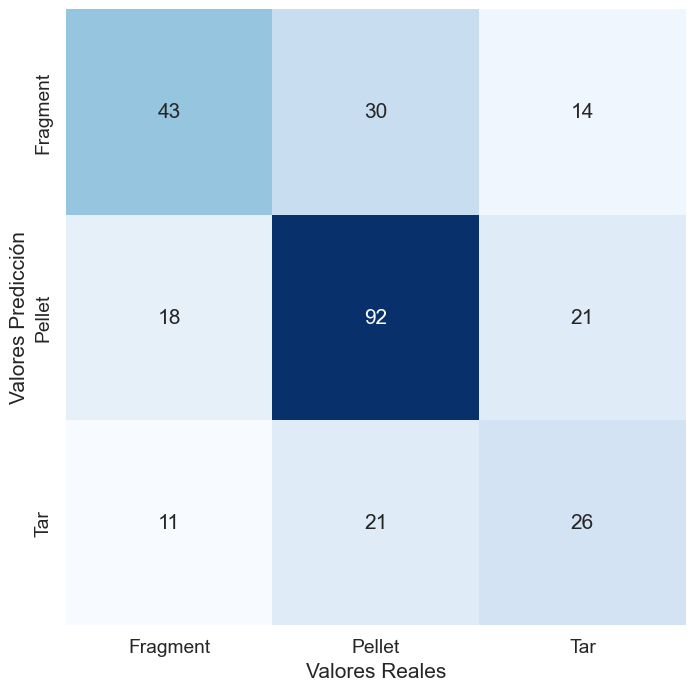

In [353]:
def contar_elementos(imagen):
    # Encontrar los contornos de las imágenes
    contornos, _ = cv2.findContours(imagen, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Inicializar contadores de elementos
    fragmentos = 0
    pellet = 0
    alquitran = 0

    for contorno in contornos:
        
        # Medidas del contorno
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)
        _, _, w, h = cv2.boundingRect(contorno)
        (cx, cy), radio = cv2.minEnclosingCircle(contorno)

        # Calcular compacidad
        compacidad = (perimetro ** 2) / area if area > 0 else 0

        # Calcular medidas elípticas
        eje_mayor, eje_menor, relacion_ejes_elipse, excentricidad = 0, 0, 0, 0
        if contorno.shape[0] > 5:
            elipse = cv2.fitEllipse(contorno)
            eje_mayor = elipse[1][1]
            eje_menor = elipse[1][0]
            relacion_ejes_elipse = eje_menor / eje_mayor 

        # Calcular relación de aspecto
        relacion_aspecto = w / h

        # Calcular relación entre el área del contorno y el contenedor
        relacion_area_contenedor = area / (w * h)

        # Clasificar elementos
        if compacidad < 15.9 and np.isclose(relacion_aspecto, 1.0, rtol=1):
            pellet += 1
        elif relacion_area_contenedor < 0.65 and relacion_ejes_elipse < 0.78:
            fragmentos += 1
        else:
            alquitran += 1

    return [fragmentos, pellet, alquitran]

# Contar elementos de cada clase en cada imagen
total_frag = contar_elementos(frag_umbral)
total_pellet = contar_elementos(pel_umbral)
total_alquitran = contar_elementos(tar_umbral)

# Crear una matriz de confusión
matriz_confusion = np.array([total_frag, total_pellet, total_alquitran])

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.25)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cbar=False, cmap='Blues', 
            xticklabels=['Fragment', 'Pellet', 'Tar'], 
            yticklabels=['Fragment', 'Pellet', 'Tar'])
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predicción")
plt.show()
